In [1]:
# Nescessary imports

%matplotlib inline

# supress warnings
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # supress tensorflow warnings


# import libraries
import sys
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import rotate

import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adadelta
from sklearn.model_selection import train_test_split

# set random seed
random.seed(42)

%load_ext autoreload

In [2]:
%autoreload 2
from classes.data_wraper import Dataset

In [3]:
# mount google drive if using google colab
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')

In [ ]:
channels = ['FOVfitting_2']#, '3quadrants_2', 'FOVfitting_3', '3quadrants_3', 'FOVfitting_4', '3quadrants_4', 'FOVfitting_5', '3quadrants_5', 'FOVfitting_6', '3quadrants_6', 'FOVfitting_9', '3quadrants_9']
dataset = Dataset(channels)

In [ ]:
dataset.preprocess_data()
dataset.crop_data(128)

In [8]:
df = dataset.df
X = np.stack((df['map1'].to_list(), df['map2'].to_list(), df['map3'].to_list()), axis=3)
y = np.array(df['combined'].to_list())
azimut = np.array(df['azimut'].to_list())

In [9]:
print(np.min(X), np.max(X))
print(np.min(y), np.max(y))

0.0 1.0
0.4221486449241638 1.0


In [10]:
X_train, X_test, y_train, y_test, azimut_train, azimut_test = train_test_split(X, y, azimut, test_size=0.2, random_state=42)

In [11]:
%autoreload 2
from classes.UNet import UNet
from classes.Experiment import Experiment
from classes.utils import plot_map, plot_radial_profile

In [31]:
# Experiment
model = "UNet"
name = "MSE"

learning_rate = 0.001
optimiser = tf.keras.optimizers.Adam(learning_rate=learning_rate, clipvalue=0.3, weight_decay=0.0005)
#loss = tf.keras.losses.MeanAbsoluteError()
loss = tf.keras.losses.MeanSquaredError()
input_size = (X.shape[1], X.shape[2], 3)
output_size = (y.shape[1], y.shape[2], 1)
filters = [64, 128, 256]
blocks = [2, 4, 2]
dropout = 0.3

batch_size = 1
epochs = 20
if "google.colab" in sys.modules:
    root_dir = os.path.join(
        os.getcwd(), "drive", "MyDrive", "Colab Notebooks"
    )
    data_dir = os.path.join(root_dir, "data")
    csv_path = os.path.join(root_dir, 'results', model + '.csv')
else:
    root_dir = os.getcwd()
    data_dir = os.path.join(root_dir, "data")
    csv_path = os.path.join(root_dir, 'results', model + '.csv')

In [32]:
experiment = Experiment(model, name, optimiser, learning_rate, loss, input_size, output_size, filters, blocks, dropout, epochs, batch_size, csv_path)

In [33]:
experiment.make(X_train, y_train, X_test, y_test)

Epoch 1/20
3261/3261 [==============================] - 49s 12ms/step - loss: 8.1955e-04 - val_loss: 0.0024
Epoch 2/20
3261/3261 [==============================] - 40s 12ms/step - loss: 2.0785e-04 - val_loss: 0.0011
Epoch 3/20
3261/3261 [==============================] - 40s 12ms/step - loss: 1.9070e-04 - val_loss: 0.0073
Epoch 4/20
3261/3261 [==============================] - 40s 12ms/step - loss: 1.7923e-04 - val_loss: 0.0387
Epoch 5/20
3261/3261 [==============================] - 40s 12ms/step - loss: 1.6733e-04 - val_loss: 0.0035
Epoch 6/20
3261/3261 [==============================] - 40s 12ms/step - loss: 1.5866e-04 - val_loss: 0.0047
Epoch 7/20
2399/3261 [=====================>........] - ETA: 10s - loss: 1.5923e-04

KeyboardInterrupt: ignored

In [ ]:
experiment.save_experiment_csv()

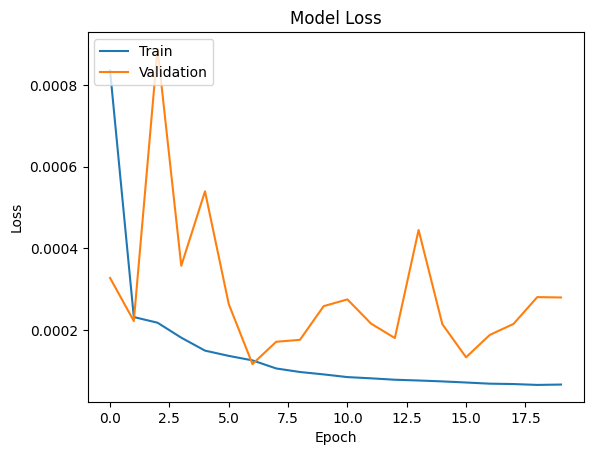

In [15]:
unet = experiment.get_model()

unet.plot_loss()

#unet.summary(graph=False, graph_name="unet_1")

In [ ]:
df = pd.read_csv(csv_path)
#df.head(len(df))
#df.describe()
df.iloc[-1]

Experiment number                            30
Name                                        MSE
Date                 2023-06-21 10:45:22.399193
Optimizer                                  Adam
Learning rate                             0.001
Loss                           MeanSquaredError
Input shape                       (128, 128, 3)
Output shape                      (128, 128, 1)
Filters                          [64, 128, 256]
Dropout                                     0.2
Epochs                                       20
Batch size                                    1
Test SSIM                               0.94743
Test PSNR                             35.441753
Test MSE                               0.000286
Name: 29, dtype: object

In [8]:
if 'google.colab' in sys.modules:
    root_dir = os.path.join(
        os.getcwd(), "drive", "MyDrive", "Colab Notebooks"
    )
    model_path = os.path.join(root_dir, model + '_mse')
else:
    root_dir = os.getcwd()
    model_path = os.path.join(root_dir, model + '_mse')
#unet.save_model(model_path)

NameError: name 'model' is not defined

In [6]:
from classes.UNet import UNet
unet = None
unet = UNet(model_path=model_path)

NameError: name 'model_path' is not defined

In [1]:
ind = random.randint(0, X_test.shape[0]-1)
pred = unet.predict(X_test[ind:ind+1])
plot_map(pred[0,:,:,0])
plot_map(y_test[ind])
plot_radial_profile([pred[0,:,:,0], y_test[ind]], azimut_test[ind])

NameError: ignored